# Machine Learning
We will touch on the followings:
- Finalizing data
- Evaluation metrics 
- Model selection 
- Model optimization
- Result


## Finalizing Data
I decided to add __tf-idf features__ in storytelling project. The stopwords consist of default stopwords provided by nltk module. On one hand, the goal is having good features that help predict the rating of helpfulness, and on the other hand, I should be careful not to have too large sparse dataset - minding the curse of dimensionality. By nature, tf-idf matrix (vectors) is a sparse matrix because each entry will have either 0 or some floating value according to if the term (word) is used in the document (review) or not. If we extract many features, say, 10,000. Less than 1% of the entries will have values and can be used for prediction and thanks to the sparsity and dimension running time for fitting machine learning models would take much longer. Therefore, after some experiments, I retrieved 500 features that excluded stopwords, words used less than 0.5% and more than 90%. To reduce sparsity, I __reduced the dimension with SVD__ approach to 300 features which hold 76.5% of the variance of the original 500 tf-idf features. 

Next, I converted __categories to numerical values__ using one-hot encoding. Finally, all features are __combined__ and ready for machine learning models. 

At this point, the data was split into training and test sets and their sizes are  (994,035 x 333) and (248,510 x 333) respectively and all categorical and textual features are transformed into numerical values through dummy variables and tf-idf features. Since the range of values of each feature varies, in some machine learning algorithms, objective function will not work properly without normalization. Therefore, the range of all features should be __normalized__ so that each feature contributes approximately on the same scale and furthermore, outliers will less impact on the results. Also, gradient descent converges much faster with feature scaling than without. I used the data standardization approach to make the values of each feature in the data have zero-mean (when subtracting the mean in the numerator) and unit-variance


### Import libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import time
import re
import gc
from textblob import Word, TextBlob
from nltk.corpus import stopwords
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import log_loss, roc_curve, auc, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.utils.fixes import signature

from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
import itertools
from itertools import cycle
from scipy import interp
import warnings
warnings.filterwarnings('ignore')

## Setup Seaborn
sns.set(style='whitegrid', font_scale=0.8, rc={"lines.linewidth":2, 'grid.color': '.8', 'grid.linestyle':':'})
## Set up Matplotlib
matplotlib.rc('xtick', labelsize=12)     
matplotlib.rc('ytick', labelsize=12)

In [2]:
## read dataframe from story telling procedure
df_train = pd.read_csv('./data/df_train_v5.csv.gz', compression='gzip', parse_dates=['reviewTime'], low_memory=False)
df_test = pd.read_csv('./data/df_test_v5.csv.gz', compression='gzip', parse_dates=['reviewTime'], low_memory=False)

## drop 'helpful_den'. Reference data_wrangling.ipynb
df_train.drop(columns=['helpful_den'], inplace=True)
df_test.drop(columns=['helpful_den'], inplace=True)

In [3]:
## check the head of df_train
df_train.head(3)

,reviewerID,asin,reviewTime,categories,helpful_num,review,polarity,word_count,word_density,helpfulness,helpfulness_cont
0,A3DMPV6RWRHPM3,0306813920,2005-11-30,Books,26,"Informative, but unbalanced.. This bio gave me...",0.256913,353,5.779661,5.0,4.642857
1,AZYJ9TS07B02W,B000O178BY,2007-04-19,CDs & Vinyl,8,"Boogie Apocalypse. Yeow, what a disappointment...",-0.016427,189,6.021053,2.0,1.904762
2,A18U7ZLAA90PNM,B004TLH6HQ,2011-06-07,Electronics,26,False advertising - Does NOT fit IPad 2. I hav...,-0.022692,154,5.148387,5.0,4.814815


In [4]:
## check the head of df_test
df_test.head(3)

,reviewerID,asin,reviewTime,categories,helpful_num,review,polarity,word_count,word_density,helpfulness,helpfulness_cont
0,AQRVDI6DFSZ86,B001MYIXAC,2009-04-02,Movies & TV,27,"Great Film, Great Transfer, BOGUS SUBTITLES!. ...",0.173042,252,6.351779,4.0,4.354839
1,A1248JRIINWRTH,B000NQ95H0,2009-10-10,Home & Kitchen,10,Terrific quality for a great price. I was a li...,0.156119,192,5.673575,5.0,4.545455
2,A2F540P3L6P5CL,0547074239,2008-08-31,Books,9,In need of some serious overhaul prior to publ...,-0.007879,197,5.474747,3.0,3.214286


In [5]:
## dimension check
df_train.shape, df_test.shape

((994035, 11), (248510, 11))

As we did in EDA project, let's combine categories 'Electronics' and 'All Electronics' into one 'Electronics'

In [6]:
## Merge All Electronics to Electronics
df_train.categories = df_train.categories.replace({'All Electronics': 'Electronics'})
df_test.categories = df_test.categories.replace({'All Electronics': 'Electronics'})

### Tfidf features

In [7]:
## prepare stopwords to remove frequent words
text = df_train.review.str.cat(sep=" ")
stopwords_set = stopwords.words('english') \
                + ['quot', 'Ye', 'dr', 'etc', 'mr', 'ye', 'yes', 'paul', 'oh', 'hes', 'shes',
                  'b', 'c', 'de', 'f', 'ii', 'im', 'ive', 'la', 'michael', 'ms', 'miss', 'theres',
                  'p', 'w', 'x', 'youll', 'youre', 'youd', 'cds', 'youve', 'ill', 'theyre',
                  'theyd', 'therere', 'thats']
stopwords_set = set([re.sub("[^a-zA-Z]", "", word).lower() for word in stopwords_set]) - {""}

## read in already normalized, lemmatized clean text dataframes from storytelling.ipynb
X_train_review_clean = pd.read_csv('./data/X_train_review_clean.csv.gz', header=None, compression='gzip', low_memory=False)
X_test_review_clean = pd.read_csv('./data/X_test_review_clean.csv.gz', header=None, compression='gzip', low_memory=False)

## by default, pd.read_csv reads data in dataframe. Change it to pd.Series
X_train_review_clean = X_train_review_clean[0]
X_test_review_clean = X_test_review_clean[0]
X_train_review_clean = X_train_review_clean.drop(index=487970)
X_train_review_clean.reset_index(inplace=True, drop=True)

In [8]:
df_train.review.tail(3)

994032    A nakedly predatory government. This book cont...
994033    Reggae is the first &quot;Bass&quot; music.. T...
994034    A great, durable toy!  We love it!. We have us...
Name: review, dtype: object

In [9]:
X_train_review_clean.tail(3)

994032    a nakedly predatory government this book conta...
994033    reggae be the first quotbassquot music the rea...
994034    a great durable toy we love it we have use thi...
Name: 0, dtype: object

In [10]:
## filter out stop words of English, and too frequently used words are out, 
## words used in less than 1% and more than 90% reviews excluded
## After running several times this code block, max_df: 0.55~0.90 does not change vocabulary number 
## take top 500 frequent terms 
vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,1), 
                             min_df=0.005, max_df=0.9, max_features=500, stop_words=stopwords_set)

V_train = vectorizer.fit_transform(X_train_review_clean.astype('U'))
V_test = vectorizer.transform(X_test_review_clean.astype('U'))

## dimension and type check
V_train.shape, V_train

((994035, 500), <994035x500 sparse matrix of type '<class 'numpy.float64'>'
 	with 35161389 stored elements in Compressed Sparse Row format>)

### Dimension reduction with TruncatedSVD

In [11]:
## Dimension reduction to 300
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=7979)
svd.fit(V_train)

print("Reduced 300-feature data holds {:.2f} % variance of the original data".format(svd.explained_variance_ratio_.sum() * 100))

## transform arrays
V_train_new = svd.transform(V_train)
V_test_new = svd.transform(V_test)

## change to data frames
columns = ['pc'+str(i) for i in range(1, 300+1)]
V_train_new = pd.DataFrame(V_train_new, columns=columns)
V_test_new = pd.DataFrame(V_test_new, columns=columns)

## dimension check
V_train_new.shape, V_test_new.shape

Reduced 300-feature data holds 76.50 % variance of the original data


((994035, 300), (248510, 300))

### Get dummy variables for categories

In [12]:
## get dummy variabels for categories
train_cat = pd.get_dummies(df_train.categories, prefix='cat')
test_cat = pd.get_dummies(df_test.categories, prefix='cat')

## drop original review, categories columns and concatenate dummy variables
df_train = pd.concat([df_train.drop(columns=['categories']), train_cat], axis=1)
df_test = pd.concat([df_test.drop(columns=['categories']), test_cat], axis=1)

## check dimension
df_train.shape, df_test.shape

((994035, 39), (248510, 39))

### Put it all together!

In [13]:
## index reset for V_new dataframes
V_train_new.index = df_train.index
V_test_new.index = df_test.index

## Combine all data frames 
df_train = pd.concat([df_train.drop(columns=['review']), V_train_new], axis=1)
df_test = pd.concat([df_test.drop(columns=['review']), V_test_new], axis=1)

## check dimension
df_train.shape, df_test.shape

((994035, 338), (248510, 338))

In [14]:
## check
df_train.head(3)

,reviewerID,asin,reviewTime,helpful_num,polarity,word_count,word_density,helpfulness,helpfulness_cont,cat_Appliances,...,pc291,pc292,pc293,pc294,pc295,pc296,pc297,pc298,pc299,pc300
0,A3DMPV6RWRHPM3,0306813920,2005-11-30,26,0.256913,353,5.779661,5.0,4.642857,0,...,0.000916,0.000980,0.043833,-0.024064,0.050780,0.019206,0.031914,-0.074663,0.018306,0.002274
1,AZYJ9TS07B02W,B000O178BY,2007-04-19,8,-0.016427,189,6.021053,2.0,1.904762,0,...,0.011577,0.070856,0.018432,-0.030864,0.012951,0.007137,0.005295,-0.030158,-0.000270,-0.022173
2,A18U7ZLAA90PNM,B004TLH6HQ,2011-06-07,26,-0.022692,154,5.148387,5.0,4.814815,0,...,-0.044844,0.039765,-0.001858,0.008777,-0.031732,0.009721,0.037427,0.003369,0.002864,0.015834


### Standardization

In [15]:
## standardize numerical features
columns = df_train.columns.drop(['reviewerID', 'asin', 'reviewTime', 'helpfulness', 'helpfulness_cont'])

## standardizing them
scaler = StandardScaler()
X_train = df_train[columns].copy()
X_test = df_test[columns].copy()
X_train[columns] = scaler.fit_transform(df_train[columns])
X_test[columns] = scaler.transform(df_test[columns])

## Split into predictors and response
y_train = df_train.helpfulness.astype(int)
y_test = df_test.helpfulness.astype(int)
y_train_cont = df_train.helpfulness_cont.astype(float)
y_test_cont = df_test.helpfulness_cont.astype(float)

## check dimension and summary statistics
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, y_train_cont.shape, y_test_cont.shape)
X_train.describe()

(994035, 333) (248510, 333) (994035,) (248510,) (994035,) (248510,)


,helpful_num,polarity,word_count,word_density,cat_Appliances,cat_Apps for Android,"cat_Arts, Crafts & Sewing",cat_Automotive,cat_Baby,cat_Baby Products,...,pc291,pc292,pc293,pc294,pc295,pc296,pc297,pc298,pc299,pc300
count,9.940350e+05,9.940350e+05,9.940350e+05,9.940350e+05,9.940350e+05,9.940350e+05,9.940350e+05,9.940350e+05,9.940350e+05,9.940350e+05,...,9.940350e+05,9.940350e+05,9.940350e+05,9.940350e+05,9.940350e+05,9.940350e+05,9.940350e+05,9.940350e+05,9.940350e+05,9.940350e+05
mean,2.263874e-15,6.534716e-16,3.178963e-18,-2.906643e-15,-1.237060e-14,5.508378e-15,9.652709e-15,-6.287996e-15,-9.006816e-16,-1.522496e-14,...,-2.299890e-18,3.366962e-18,-1.945614e-18,6.080547e-18,-1.078716e-18,1.310777e-18,2.982084e-20,1.786458e-17,4.510653e-18,-2.818035e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-3.858955e-01,-6.107783e+00,-8.906789e-01,-7.708145e+00,-3.248694e-02,-2.016407e-02,-6.454480e-02,-7.705355e-02,-8.598274e-02,-2.807703e-02,...,-6.239036e+00,-5.986624e+00,-6.256603e+00,-6.103023e+00,-6.292563e+00,-6.835540e+00,-6.965301e+00,-6.554165e+00,-6.455366e+00,-5.676507e+00
25%,-2.427416e-01,-5.158972e-01,-5.810408e-01,-6.267717e-01,-3.248694e-02,-2.016407e-02,-6.454480e-02,-7.705355e-02,-8.598274e-02,-2.807703e-02,...,-6.206367e-01,-5.989695e-01,-5.973460e-01,-6.008682e-01,-6.070339e-01,-5.834755e-01,-5.921040e-01,-5.942885e-01,-5.954964e-01,-6.164806e-01
50%,-1.711646e-01,-4.505516e-04,-3.058070e-01,-4.992894e-02,-3.248694e-02,-2.016407e-02,-6.454480e-02,-7.705355e-02,-8.598274e-02,-2.807703e-02,...,-4.091867e-02,6.597328e-03,-1.682267e-02,-2.684273e-02,-2.400031e-02,4.721834e-03,6.934667e-03,-5.100388e-04,-1.191007e-03,-3.559605e-02
75%,-1.011632e-02,5.287848e-01,2.145569e-01,5.737709e-01,-3.248694e-02,-2.016407e-02,-6.454480e-02,-7.705355e-02,-8.598274e-02,-2.807703e-02,...,5.813240e-01,5.812292e-01,5.910859e-01,5.678733e-01,5.871622e-01,5.832321e-01,5.909422e-01,6.040692e-01,5.868424e-01,5.673077e-01
max,1.450049e+02,4.478505e+00,2.551027e+01,1.526134e+02,3.078160e+01,4.959317e+01,1.549312e+01,1.297799e+01,1.163024e+01,3.561630e+01,...,6.946723e+00,1.070834e+01,6.833154e+00,7.877469e+00,6.787650e+00,7.891373e+00,8.332848e+00,6.898545e+00,7.318787e+00,8.028137e+00


In [16]:
X_train.head(3)

,helpful_num,polarity,word_count,word_density,cat_Appliances,cat_Apps for Android,"cat_Arts, Crafts & Sewing",cat_Automotive,cat_Baby,cat_Baby Products,...,pc291,pc292,pc293,pc294,pc295,pc296,pc297,pc298,pc299,pc300
0,0.079355,0.545238,0.618807,0.407405,-0.032487,-0.020164,-0.064545,-0.077054,-0.085983,-0.028077,...,0.019798,0.034123,1.228988,-0.675482,1.424845,0.537845,0.902128,-2.113010,0.518491,0.065815
1,-0.242742,-0.901591,-0.086480,0.925712,-0.032487,-0.020164,-0.064545,-0.077054,-0.085983,-0.028077,...,0.318694,1.996536,0.515086,-0.866767,0.358773,0.197507,0.150096,-0.853313,-0.008761,-0.628204
2,0.079355,-0.934753,-0.236999,-0.948043,-0.032487,-0.020164,-0.064545,-0.077054,-0.085983,-0.028077,...,-1.263031,1.123362,-0.055160,0.248321,-0.900454,0.270392,1.057880,0.095681,0.080202,0.450757


In [17]:
X_test.head(3)

,helpful_num,polarity,word_count,word_density,cat_Appliances,cat_Apps for Android,"cat_Arts, Crafts & Sewing",cat_Automotive,cat_Baby,cat_Baby Products,...,pc291,pc292,pc293,pc294,pc295,pc296,pc297,pc298,pc299,pc300
0,0.097249,0.101299,0.184453,1.635835,-0.032487,-0.020164,-0.064545,-0.077054,-0.085983,-0.028077,...,-0.888760,1.402881,-0.345657,1.600091,-0.352617,0.224226,-0.737839,-0.362477,0.721077,0.301940
1,-0.206953,0.011722,-0.073578,0.179621,-0.032487,-0.020164,-0.064545,-0.077054,-0.085983,-0.028077,...,0.635713,-0.263205,-0.226017,-0.288725,0.165793,0.626736,1.226747,-1.705301,0.807695,1.193713
2,-0.224847,-0.856343,-0.052076,-0.247294,-0.032487,-0.020164,-0.064545,-0.077054,-0.085983,-0.028077,...,-0.939384,-0.850536,-0.280764,0.598922,0.207041,-0.211342,1.546686,-3.212702,-1.744393,1.185748


In [20]:
# ## For later use
# pd.concat([X_train, y_train, y_train_cont], axis=1).to_csv('./data/df_train_vfinal.csv.gz', encoding='utf-8', index=False, compression='gzip')
# pd.concat([X_test, y_test, y_test_cont], axis=1).to_csv('./data/df_test_vfinal.csv.gz', encoding='utf-8', index=False, compression='gzip')

## freeing unnecessary variables from memories
for bye in [V_train, V_test, V_train_new, V_test_new, train_cat, test_cat]:
    bye = None
gc.collect();

In [21]:
# ## read dataframe from story telling procedure
df_train = pd.read_csv('./data/df_train_vfinal.csv.gz', compression='gzip', low_memory=False)
df_test = pd.read_csv('./data/df_test_vfinal.csv.gz', compression='gzip', low_memory=False)

## split into X, y and train and test set
X_train = df_train.drop(columns=['helpfulness', 'helpfulness_cont'])
y_train = df_train.helpfulness # for classification
y_train_cont = df_train.helpfulness_cont # for regression
X_test = df_test.drop(columns=['helpfulness', 'helpfulness_cont'])
y_test = df_test.helpfulness # for classification
y_test_cont = df_test.helpfulness_cont # for regression

## freeing unnecessary variables from memories
for bye in [df_train, df_test]:
    bye = None
gc.collect();

## check 
X_train.shape, X_test.shape, y_train.shape, y_test.shape, y_train_cont.shape, y_test_cont.shape  

((994035, 333), (248510, 333), (994035,), (248510,), (994035,), (248510,))

## Define Helper Functions
Below are helpfer functions for visualization.

In [22]:
def plot_PR_curve(recall, precision, ap, n_classes = 6, is_sep=False):
    """
    Plot (micro-averaged) Precision-Recall curve(s).
    
    > Parameters:
    recall: dictionary of list of recall values for each class [0-5] for different probability thresholds
    Precision: dictionary of list of precision values for each class for different probability thresholds
    ap: average precision from prediction scores for each class
    n_classes: number of classes; default=6
    is_sep: whether to plot curves for each class
    
    > Returns: None
    """
    
    if not is_sep: 
        plt.figure(figsize=(12, 8))
        step_kwargs = ({'step': 'post'}
                       if 'step' in signature(plt.fill_between).parameters
                       else {})
        plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
                 where='post')
        plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b',
                         **step_kwargs)

        plt.xlabel('Recall', fontsize=14)
        plt.ylabel('Precision', fontsize=14)
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title(
            'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
            .format(ap["micro"]), fontsize=16);
    ## plot for each class
    else: 
        ## setup plot details
        colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 
                        'teal', 'palevioletred'])

        plt.figure(figsize=(7, 8))
        f_scores = np.linspace(0.2, 0.8, num=4)
        lines = []
        labels = []
        for f_score in f_scores:
            x = np.linspace(0.01, 1)
            y = f_score * x / (2 * x - f_score)
            l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
            plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

        lines.append(l)
        labels.append('iso-f1 curves')
        l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
        lines.append(l)
        labels.append('micro-average Precision-recall (area = {0:0.2f})'
                      ''.format(ap["micro"]))

        for i, color in zip(range(n_classes), colors):
            l, = plt.plot(recall[i], precision[i], color=color, lw=2)
            lines.append(l)
            labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                          ''.format(i, ap[i]))

        fig = plt.gcf()
        fig.set_size_inches(12, 10)
        ## fig.subplots_adjust(bottom=0.25)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall', fontsize=14)
        plt.ylabel('Precision', fontsize=14)
        plt.title('Extension of Precision-Recall curve to multi-class', fontsize=16)
        plt.legend(lines, labels, bbox_to_anchor=(1.02, 0.04), fancybox=True, shadow=True, ncol=1, 
                   loc=(0, -.38), prop=dict(size=12))

        plt.show()

In [23]:
def plot_ROC_curve(y_true, y_score, n_classes=6, is_sep=False):
    """
    Plot (micro-averaged) ROC (Receiver operating characteristic) curve(s).
    
    > Parameters:
    y_true: binarized true labels
    y_score: Target scores, can either be probability estimates of the positive class,
             confidence values, or non-thresholded measure of decisions
    n_classes: number of classes; default=6
    is_sep: whether to plot curves for each class
    
    > Returns: None
    """
    
    ## Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    ## Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = roc_auc_score(y_true, y_score)
    lw = 2
    
    if not is_sep:
        ## display
        plt.figure(figsize=(12, 8))
        plt.plot(fpr[2], tpr[2], color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=14)
        plt.ylabel('True Positive Rate', fontsize=14)
        plt.title('Receiver operating characteristic: AUC={:.2f}'
                  .format(roc_auc["micro"]), fontsize=16)
        plt.legend(loc="lower right")
        plt.show()
    else:
        ## Compute macro-average ROC curve and ROC area
        ## First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        ## Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        ## Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        ## Plot all ROC curves
        plt.figure(figsize=(12,8))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['darkgreen', 'turquoise', 'darkorange', 'cornflowerblue', 
                        'teal', 'darkmagenta'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=14)
        plt.ylabel('True Positive Rate', fontsize=14)
        plt.title('Extension of Receiver operating characteristic to multi-class', fontsize=16)
        plt.legend(loc="lower right")
        plt.show()

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    > Parameters:
    cm: confusion matrix(y_test, y_predicted)
    normalize: whether to normalize
    title: title of plot
    cmap: color map
    
    > Returns: None
    """    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.tight_layout()

# Machine learning frameworks
I will consider simple, complex models as candidate models. That is, I will try __Logistic Regression and Gradient Boosting frameworks and evaluate them with log loss (corss-entropy loss)__. For this dataset, somehow SVM models are taking too much time for optimization, I excluded them. 

<table><tr>
    <td>
        <figure>
        <img src="https://raw.githubusercontent.com/soo-pecialist/SB_DSC/master/00_Capstone%201/Images/DataDistribution.png" style="height:300px" align='right'>
            <figcaption> Helpfulness Distribution </figcaption>
        </figure>
    </td>
</tr></table>

__Log loss__ quantifies the accuracy of a classifier by penalising false classifications. Minimising the Log Loss is basically equivalent to maximising the accuracy of the classifier, but there is a subtle twist which we will get to in a moment.

In order to calculate Log Loss the classifier must assign a probability to each class rather than simply yielding the most likely class. Let the true labels for a set of samples be encoded as a 1-of-K binary indicator matrix $Y$ , i.e., $y_{ik} =1$ if sample $i$ has label $k$ taken from a set of K labels. Let $P$ be a matrix of probability with $p_{ik} = Pr(t_{ik} = 1)$. Mathematically Log Loss is defined as

$$ \mathcal{L}_{\log}(Y, P) = -\log{Pr(Y|P)} =  -\frac{1}{N} \sum_{i=1}^{N}\sum_{k=1}^K y_{ik}\log{p_{ik}} $$

where N is the number of samples or instances, and $t_{ik}$ is the predicted binary indicator of assigning label k to instance i. __A perfect classifier would have a Log Loss of precisely zero__. Less ideal classifiers have progressively larger values of Log Loss. If there are only two classes then the expression above simplifies to


$$ \mathcal{L}_{\log}(y, p) = -\log{Pr(y|p)}= -\frac{1}{N} \sum_{i=1}^{N}[y_i\log{p_i} + (1-y_i)\log{(1-p_i)}] $$

Note that for each instance only the term for the true class actually contributes to the sum. __Log loss heavily penalises classifiers that are confident about an incorrect classification__. For example, if for a particular observation, the classifier assigns a very small probability to the true class then the corresponding contribution to the Log loss will be very large indeed. Naturally this is going to have a significant impact on the overall log loss for the classifier. Therefore, with log loss as objective function, the model will try to make less mistakes and even if it misclassifies a data point, it will try not to be so confident about the prediction on the data point. Furthurmore, the model will try to be more confident about right predictions - i.e., __be more confident about the correct predictions, and be less confident about the wrong predictions__.  

<table><tr>
    <td>
        <figure>
        <img src="https://datawookie.netlify.com/img/2015/12/log-loss-curve.png" style="height:300px" align='right'>
            <figcaption> (negative) Log Loss against probability </figcaption>
        </figure>
    </td>
</tr></table>


It is hard to make sense of what log loss means easily. Therefore, to understand how good the model is I will employ __AP (average precision), AUC (Area Under an ROC Curve), and confusion matrix__ as well.
That is, I will train/optimize model with log loss, and analyze the results with AP, AUC, and confusion matrix. Below is detailes explanation on AP, precision and recall. 

--- 

In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned. The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall). 

<table><tr>
    <td>
        <figure>
        <img src="https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg" style="height:600px" align='right'>
            <figcaption> Precision and Recall - wikipedia </figcaption>
        </figure>
    </td>
</tr></table>

Above figure is a great graphical summary of precision and recall. By definition, 
- Precision is the proportion of the data points our model says was relevant actually were relevant.
- Recall is the ability to find all relevant instances in a dataset. 
More formally,

$$ Precision = \frac{True Positives}{True Positives + False Positives}$$

$$ Recall = \frac{True Positives}{True Positives + False Negatives}$$

- Average precision (AP) summarizes a precision-recall curve. You can think of it as approximated precision-recall AUC (Area Under the Curve) score. 

$$ AP = \sum_{n}(R_{n} - R_{n-1}) P_{n}$$
Where $P_n$ and $R_n$ are the precision and recall at the $n^{th}$ threshold. Precision-recall curves are typically used in binary classification to study the output of a classifier. In order to extend the precision-recall curve and average precision to multi-class or multi-label classification, __it is necessary to binarize the output__. 

In [25]:
## Use label_binarize to be multi-label setting
Y_train = label_binarize(y_train, classes=[0, 1, 2, 3, 4, 5])
Y_test = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5] )
n_classes = Y_train.shape[1]

## setting stratifiedKFold - 3 folds
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 7777)

## Logistic Regression
Due to the fact that the problem is multiclass problem and logistic regression is by nature for binary classification, I combine it with one-vs-rest scheme. Then, the best parameter C will be searched through gridsearchCV.

In [26]:
## Grid Search for logistic regression
lr = OneVsRestClassifier(LogisticRegression(random_state=1004))
lr_params = {'estimator__C':[0.1, 0.5, 1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}

lr_grid = GridSearchCV(lr, param_grid=lr_params,
                    scoring='logloss', 
                    cv=skf.split(X_train, y_train))

## clock running time
start = time.time()
lr_grid.fit(X_train, Y_train)
end = time.time()

print("Running time for grid search with 3-fold CV: {:.0f} (sec)".format(end-start))

Running time for grid search with 3-fold CV: 5296 (sec)


In [27]:
#### run again
lr_best = lr_grid.best_estimator_
lr_score = lr_grid.best_score_
lr_params = lr_grid.best_params_

print("Training logloss: {:>8.4f}".format(log_loss(y_train, lr_best.predict_proba(X_train))))
print("Test logloss: {:>12.4f}".format(log_loss(y_test, lr_best.predict_proba(X_test))))
print("Best logistic regression estimator:")
print(lr_best)

Best logistic regression estimator:
OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1004, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)


In [31]:
## AP (Average Precision) and AUC (Area Under the Curve), precision, recall, 
## f1 scores on test data for each class
y_lr_score = lr_best.predict_proba(X_test)
lr_precision = dict()
lr_recall = dict()
lr_ap = dict()
for i in range(n_classes):
    lr_precision[i], lr_recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                              y_lr_score[:, i])
    lr_ap[i] = average_precision_score(Y_test[:, i], y_lr_score[:, i])

# A "micro-average": quantifying score on all classes jointly
lr_precision["micro"], lr_recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
                                                                      y_lr_score.ravel())
lr_ap["micro"] = average_precision_score(Y_test, y_lr_score, average="micro")
lr_auc = roc_auc_score(Y_test, y_lr_score)

print("Best logistic regression estimator micro-averaged AP score on test data:")
print("{:.4f}".format(lr_ap["micro"]))
print("Best logistic regression estimator micro-averaged AUC score on test data:")
print("{:.4f}".format(lr_auc))

Best logistic regression estimator micro-averaged AP score on test data:
0.5203
Best logistic regression estimator micro-averaged AUC score on test data:
0.8010


### Plot the precision-Recall curve

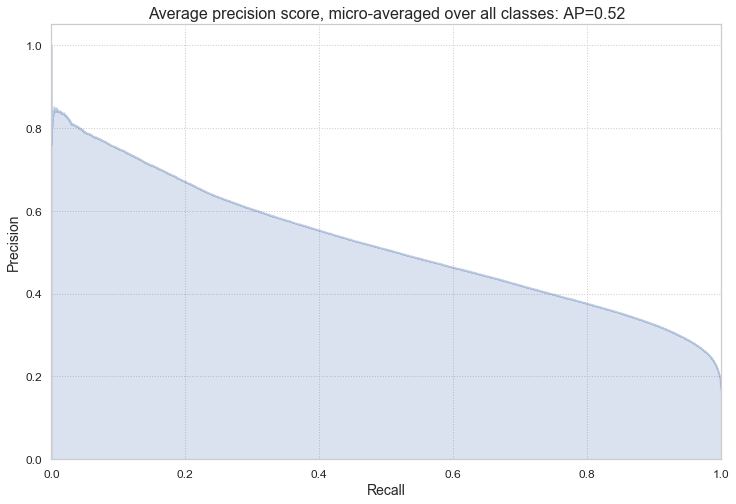

In [32]:
## Visualize PR curve for logistic regression model
plot_PR_curve(lr_recall, lr_precision, lr_ap)

### Plot Precision-Recall curve for each class and iso-f1 curves

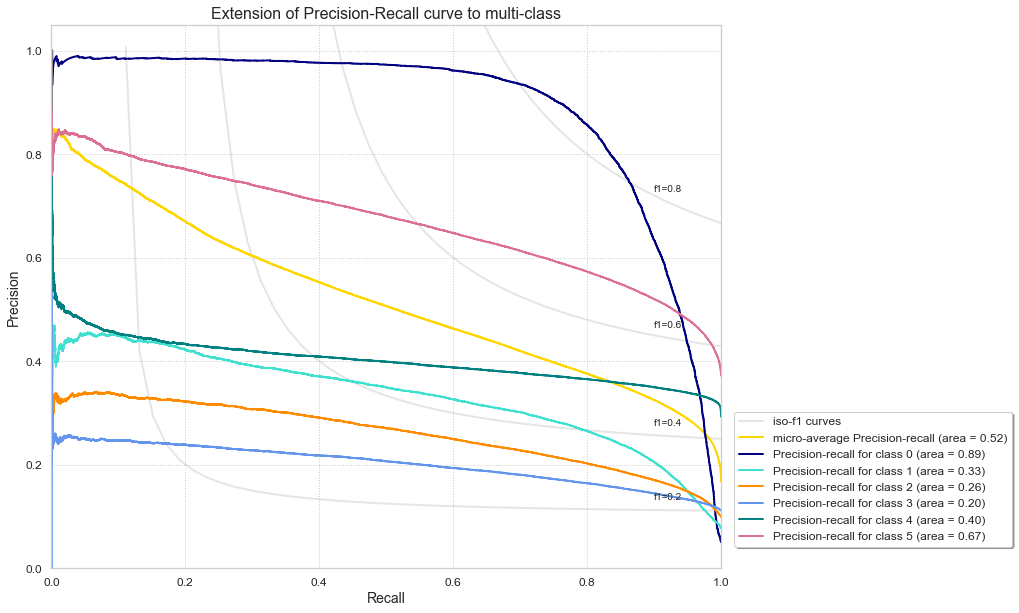

In [33]:
plot_PR_curve(lr_recall, lr_precision, lr_ap, is_sep=True)

### Plot ROC  curve 

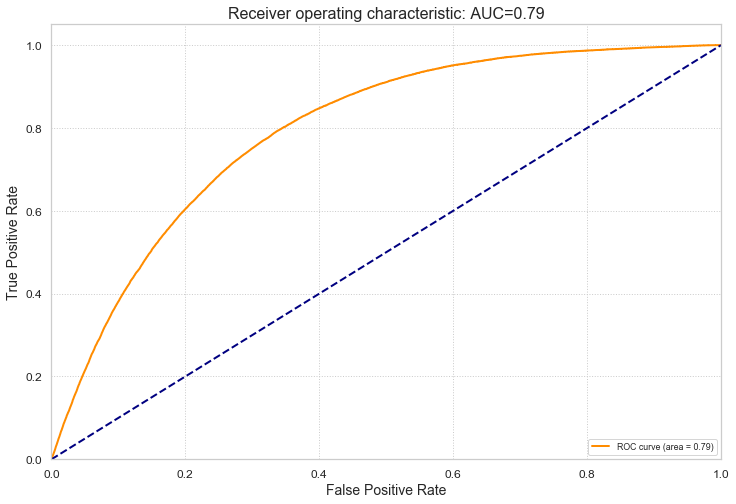

In [34]:
## Visualize ROC curve
plot_ROC_curve(Y_test, y_lr_score)

### Plot ROC curve for each class

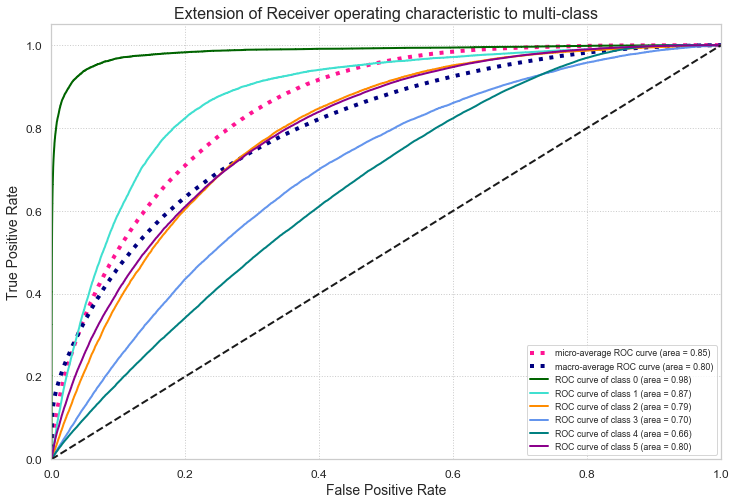

In [35]:
plot_ROC_curve(Y_test, y_lr_score, is_sep=True)

Best logistic regression model shows 0.5203 of average precision (AP) and 0.8010 of the area under the curve (AUC). As a whole, AP score does not seem so great because on average over all classes, it means 52% times model correctly predicts the score. However, when looking at individual PR curves and AP scores, logistic regression model shows good performance for class 0 and 5, which we can interpret that the logistic regression model predicts more correct on not helpful review datapoints and very helpful ones. Since I had to use one-vs-rest approach, __there are some data points that model cannot determine to which class the data points belong__. This would be one reason why AP and AUC scores are in general low - because those unable data points are regarded as errors. Overall, AUC scores look more promising than AP scores. However, you should __keep in mind that our data is left-skewed and AUC scores are likely too optimistic in this situation. It is because, by definition, AUC scores consider TPR (True Positive Rate) and FPR (False Positive Rate), and if actual class size is small such as class 0,1,2, and 3; then it is easy to achieve good accuracy by just saying that most data points belong to other classes (This will most likely reduce False Negatives)__. On the other hand, big classes such as class 4 or 5 are relatively harder to achieve good accuracy. Based on AP score results, we can assume that it was easier for the learn better in class 0 and class 5 extreme classes and struggled to distinguish middle rating classes 1,2,3, and 4.

__All in all, it seems not promising to use logistic regression model as an optimal model, especially because of the limit of one-versus-rest classifier__.

### Important predictors

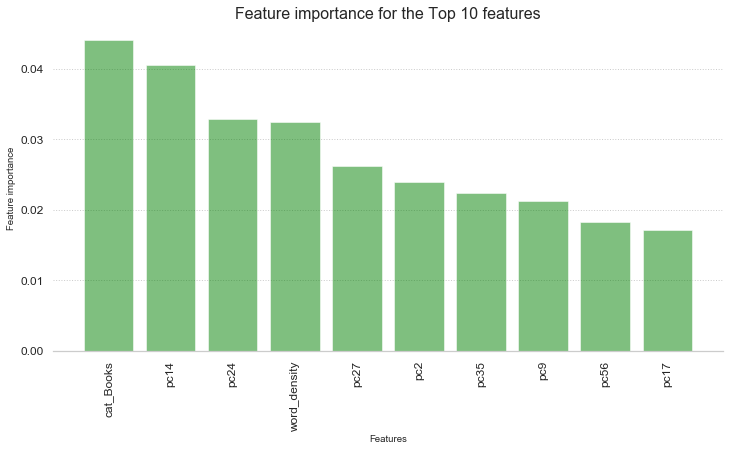

Top 10 important features:
 ['cat_Books', 'pc14', 'pc24', 'word_density', 'pc27', 'pc2', 'pc35', 'pc9', 'pc56', 'pc17']


In [36]:
## visualize it
features = sorted(zip(lr_best.coef_.mean(axis=0), X_train.columns), reverse=True)
attr = []
coef = []
number = 10

for feature in features:
    attr.append(feature[1]) 
    coef.append(feature[0])

plt.figure(figsize=(12,6))
ax = plt.subplot()
ax.bar(attr[:number], height=coef[:number], color='green', alpha=0.5)
sns.despine(top=True, right=True, left=True)
ax.xaxis.grid(False)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature importance')
plt.title('Feature importance for the Top {} features'.format(number), fontsize=16)
plt.show()

## print features
print("Top {} important features:\n {}".format(number, attr[:number]))

Logistic regression ranks feature importance based on regression coefficients. Whether it is Books category and word density play a big role to predict the helpfulness. We cannot interpret those principal components such as pc14 and pc24 directly - we can reconstruct original featrues and see how principal components are composed. Still, it is interesting that helpful_num, polarity, word_count did not make it to the top 10 list. Based on the logistic regression model, there exist important vocabulary groups that can help to distinguish reviews' helpfulness. I will delve into it with Gradient Boosting model.

## Gradient Boosting 
Tree based models can be used for both regression and classification. From the logistic regresion result, we can assume that predicting helpfulness with non-gradient descent approach would be hard - target is highly skewed and reference model struggles with middle classes. 

Thus, it is natural to turn our head to gradient boosting for one, it is sequential model; therefore previous iteration turnout nudges the model in the direction where loss can be reduced maximally. First, we will see how default XGBclassifier performs and compare it with the performance of optimized XGBclassifer. 

To prevent overfitting to training data, I will employ validation data and their ratio is $train:validataion:test = 6:2:2$

### Default XGB model

In [37]:
## train:validation:test = 6:2:2
folds = 8  
skf_val = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1234)

X_valids = []
y_valids = []
for _, valid_index in skf_val.split(X_train, y_train):
    X_valids.append(X_train.iloc[valid_index])
    y_valids.append(y_train.iloc[valid_index])

## training set
X_train_sub = X_train.drop(pd.concat(X_valids[0:2], axis=0).index)
y_train_sub = y_train.drop(pd.concat(y_valids[0:2], axis=0).index)
## validation set
X_valid = pd.concat(X_valids[0:2], axis=0)
y_valid = pd.concat(y_valids[0:2], axis=0)

X_train_sub.shape, y_train_sub.shape, X_valid.shape, y_valid.shape

((745521, 333), (745521,), (248514, 333), (248514,))

In [40]:
## set for default classifier 
start=time.time()
param = dict(booster='gbtree', objective='multi:softprob', num_class=6, seed=23, silent=True)
xgb_clf = xgb.XGBClassifier(**param, n_estimators=1280, n_jobs=128)
## fit the default model to training dataset
xgb_clf.fit(X_train_sub, y_train_sub, eval_metric="mlogloss", early_stopping_rounds=5, 
            eval_set=[(X_valid, y_valid)], verbose=True)
end=time.time()
print("runtime: {:.0f} sec".format(end-start))

[0]	validation_0-mlogloss:1.69371
Will train until validation_0-mlogloss hasn't improved in 5 rounds.
[1]	validation_0-mlogloss:1.6136
[2]	validation_0-mlogloss:1.54629
[3]	validation_0-mlogloss:1.48869
[4]	validation_0-mlogloss:1.43903
[5]	validation_0-mlogloss:1.39569
[6]	validation_0-mlogloss:1.35753
[7]	validation_0-mlogloss:1.32368
[8]	validation_0-mlogloss:1.29337
[9]	validation_0-mlogloss:1.26652
[10]	validation_0-mlogloss:1.24242
[11]	validation_0-mlogloss:1.2208
[12]	validation_0-mlogloss:1.2011
[13]	validation_0-mlogloss:1.18349
[14]	validation_0-mlogloss:1.16749
[15]	validation_0-mlogloss:1.15307
[16]	validation_0-mlogloss:1.13994
[17]	validation_0-mlogloss:1.12799
[18]	validation_0-mlogloss:1.11701
[19]	validation_0-mlogloss:1.10698
[20]	validation_0-mlogloss:1.09776
[21]	validation_0-mlogloss:1.08933
[22]	validation_0-mlogloss:1.08152
[23]	validation_0-mlogloss:1.07436
[24]	validation_0-mlogloss:1.06768
[25]	validation_0-mlogloss:1.06156
[26]	validation_0-mlogloss:1.05583


[225]	validation_0-mlogloss:0.946544
[226]	validation_0-mlogloss:0.946485
[227]	validation_0-mlogloss:0.946426
[228]	validation_0-mlogloss:0.946343
[229]	validation_0-mlogloss:0.946254
[230]	validation_0-mlogloss:0.946177
[231]	validation_0-mlogloss:0.946109
[232]	validation_0-mlogloss:0.946044
[233]	validation_0-mlogloss:0.945988
[234]	validation_0-mlogloss:0.945925
[235]	validation_0-mlogloss:0.945868
[236]	validation_0-mlogloss:0.945795
[237]	validation_0-mlogloss:0.945746
[238]	validation_0-mlogloss:0.945691
[239]	validation_0-mlogloss:0.945632
[240]	validation_0-mlogloss:0.945567
[241]	validation_0-mlogloss:0.945516
[242]	validation_0-mlogloss:0.945441
[243]	validation_0-mlogloss:0.945382
[244]	validation_0-mlogloss:0.945327
[245]	validation_0-mlogloss:0.945275
[246]	validation_0-mlogloss:0.945218
[247]	validation_0-mlogloss:0.94516
[248]	validation_0-mlogloss:0.945099
[249]	validation_0-mlogloss:0.945041
[250]	validation_0-mlogloss:0.944974
[251]	validation_0-mlogloss:0.944914
[2

[448]	validation_0-mlogloss:0.937693
[449]	validation_0-mlogloss:0.937663
[450]	validation_0-mlogloss:0.937643
[451]	validation_0-mlogloss:0.93762
[452]	validation_0-mlogloss:0.937585
[453]	validation_0-mlogloss:0.937558
[454]	validation_0-mlogloss:0.937525
[455]	validation_0-mlogloss:0.937502
[456]	validation_0-mlogloss:0.937484
[457]	validation_0-mlogloss:0.937461
[458]	validation_0-mlogloss:0.937441
[459]	validation_0-mlogloss:0.937417
[460]	validation_0-mlogloss:0.937391
[461]	validation_0-mlogloss:0.937371
[462]	validation_0-mlogloss:0.937341
[463]	validation_0-mlogloss:0.937323
[464]	validation_0-mlogloss:0.937299
[465]	validation_0-mlogloss:0.937276
[466]	validation_0-mlogloss:0.937253
[467]	validation_0-mlogloss:0.937227
[468]	validation_0-mlogloss:0.937206
[469]	validation_0-mlogloss:0.937189
[470]	validation_0-mlogloss:0.937169
[471]	validation_0-mlogloss:0.937157
[472]	validation_0-mlogloss:0.937138
[473]	validation_0-mlogloss:0.937113
[474]	validation_0-mlogloss:0.937097
[4

[670]	validation_0-mlogloss:0.933826
[671]	validation_0-mlogloss:0.933806
[672]	validation_0-mlogloss:0.933793
[673]	validation_0-mlogloss:0.933784
[674]	validation_0-mlogloss:0.933781
[675]	validation_0-mlogloss:0.933766
[676]	validation_0-mlogloss:0.933756
[677]	validation_0-mlogloss:0.933747
[678]	validation_0-mlogloss:0.933734
[679]	validation_0-mlogloss:0.933722
[680]	validation_0-mlogloss:0.933698
[681]	validation_0-mlogloss:0.933685
[682]	validation_0-mlogloss:0.933674
[683]	validation_0-mlogloss:0.933662
[684]	validation_0-mlogloss:0.933649
[685]	validation_0-mlogloss:0.933641
[686]	validation_0-mlogloss:0.933618
[687]	validation_0-mlogloss:0.933612
[688]	validation_0-mlogloss:0.933595
[689]	validation_0-mlogloss:0.933582
[690]	validation_0-mlogloss:0.933573
[691]	validation_0-mlogloss:0.933561
[692]	validation_0-mlogloss:0.933546
[693]	validation_0-mlogloss:0.933532
[694]	validation_0-mlogloss:0.933516
[695]	validation_0-mlogloss:0.9335
[696]	validation_0-mlogloss:0.933491
[69

[893]	validation_0-mlogloss:0.931722
[894]	validation_0-mlogloss:0.931703
[895]	validation_0-mlogloss:0.931699
[896]	validation_0-mlogloss:0.931689
[897]	validation_0-mlogloss:0.931682
[898]	validation_0-mlogloss:0.93168
[899]	validation_0-mlogloss:0.931679
[900]	validation_0-mlogloss:0.93167
[901]	validation_0-mlogloss:0.931655
[902]	validation_0-mlogloss:0.931646
[903]	validation_0-mlogloss:0.931649
[904]	validation_0-mlogloss:0.931644
[905]	validation_0-mlogloss:0.931635
[906]	validation_0-mlogloss:0.931633
[907]	validation_0-mlogloss:0.931627
[908]	validation_0-mlogloss:0.931621
[909]	validation_0-mlogloss:0.931618
[910]	validation_0-mlogloss:0.931611
[911]	validation_0-mlogloss:0.931602
[912]	validation_0-mlogloss:0.931596
[913]	validation_0-mlogloss:0.931591
[914]	validation_0-mlogloss:0.931581
[915]	validation_0-mlogloss:0.931575
[916]	validation_0-mlogloss:0.931568
[917]	validation_0-mlogloss:0.931557
[918]	validation_0-mlogloss:0.931549
[919]	validation_0-mlogloss:0.93154
[920

[1113]	validation_0-mlogloss:0.930424
[1114]	validation_0-mlogloss:0.930414
[1115]	validation_0-mlogloss:0.930409
[1116]	validation_0-mlogloss:0.930408
[1117]	validation_0-mlogloss:0.930403
[1118]	validation_0-mlogloss:0.930397
[1119]	validation_0-mlogloss:0.930385
[1120]	validation_0-mlogloss:0.930381
[1121]	validation_0-mlogloss:0.930375
[1122]	validation_0-mlogloss:0.93037
[1123]	validation_0-mlogloss:0.93037
[1124]	validation_0-mlogloss:0.930361
[1125]	validation_0-mlogloss:0.930358
[1126]	validation_0-mlogloss:0.930352
[1127]	validation_0-mlogloss:0.930346
[1128]	validation_0-mlogloss:0.930342
[1129]	validation_0-mlogloss:0.930342
[1130]	validation_0-mlogloss:0.930336
[1131]	validation_0-mlogloss:0.930335
[1132]	validation_0-mlogloss:0.930336
[1133]	validation_0-mlogloss:0.930334
[1134]	validation_0-mlogloss:0.930327
[1135]	validation_0-mlogloss:0.930319
[1136]	validation_0-mlogloss:0.930317
[1137]	validation_0-mlogloss:0.930314
[1138]	validation_0-mlogloss:0.930312
[1139]	validat

In [41]:
# ## set for default classifier 
# start=time.time()
# param = dict(booster='gbtree', objective='multi:softprob', num_class=6, seed=23, silent=True)
# xgb_clf = xgb.XGBClassifier(**param, n_estimators=1280, n_jobs=128)
# ## fit the default model to training dataset
# xgb_clf.fit(X_train_sub, y_train_sub, eval_metric="mlogloss", early_stopping_rounds=5, 
#             eval_set=[(X_valid, y_valid)], verbose=False)
# end=time.time()

print("runtime: {:.0f} sec".format(end-start))
print("default model:")
print(xgb_clf)

runtime: 108832 sec
default model:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1280,
       n_jobs=128, nthread=None, num_class=6, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=23, silent=True, subsample=1)


In [42]:
print("Training logloss: {:>8.4f}".format(log_loss(y_train_sub, xgb_clf.predict_proba(X_train_sub))))
print("Validation logloss: {:.4f}".format(log_loss(y_valid, xgb_clf.predict_proba(X_valid))))
print("Test logloss: {:>12.4f}".format(log_loss(y_test, xgb_clf.predict_proba(X_test))))

Training logloss:   0.8907
Validation logloss: 0.9298
Test logloss:       0.9273


In [46]:
## AP (Average Precision) and AUC (Area Under the Curve), precision, recall, 
## f1 scores on test data for each class
y_hat = xgb_clf.predict(X_test)
y_xgb_score = xgb_clf.predict_proba(X_test)
xgb_precision = dict()
xgb_recall = dict()
xgb_ap = dict()
for i in range(n_classes):
    xgb_precision[i], xgb_recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                                y_xgb_score[:, i])
    xgb_ap[i] = average_precision_score(Y_test[:, i], y_xgb_score[:, i])

# A "micro-average": quantifying score on all classes jointly
xgb_precision["micro"], xgb_recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
                                                                        y_xgb_score.ravel())
xgb_ap["micro"] = average_precision_score(Y_test, y_xgb_score, average="micro")
xgb_auc = roc_auc_score(Y_test, y_xgb_score)
xgb_f1 = f1_score(y_test, y_hat, average='micro')
xgb_acc = accuracy_score(y_test, y_hat)

print("Default XGB estimator micro-averaged AP score on test data:")
print("{:.4f}".format(xgb_ap["micro"]))
print("Default XGB estimator micro-averaged AUC score on test data:")
print("{:.4f}".format(xgb_auc))

Default XGB estimator micro-averaged AP score on test data:
0.6609
Default XGB estimator micro-averaged AUC score on test data:
0.8724


There is slight overfitting but it is not very severe. One promising fact is validation log loss and test log loss is very close which implies variance is low. 

AP and AUC have improved by 0.1406 (27%) and 0.0714 (9%) respectively from those of logistic regression's.

### Plot the precision-Recall curve for default XGB classifier

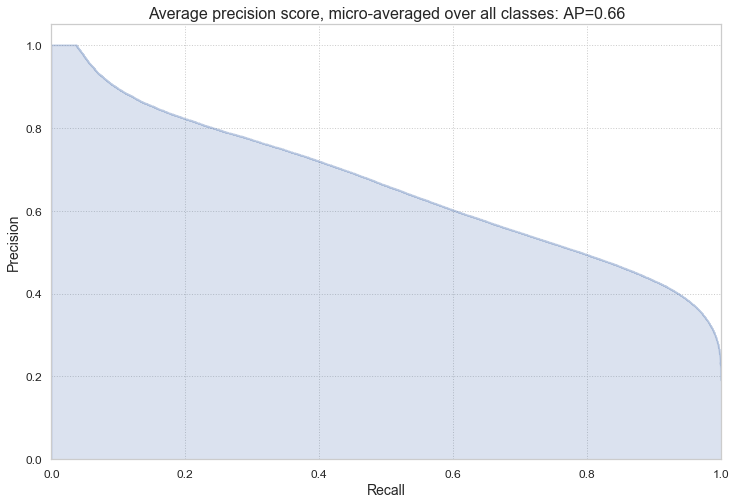

In [47]:
plot_PR_curve(xgb_recall, xgb_precision, xgb_ap)

### Plot Precision-Recall curve for each class and iso-f1 curves

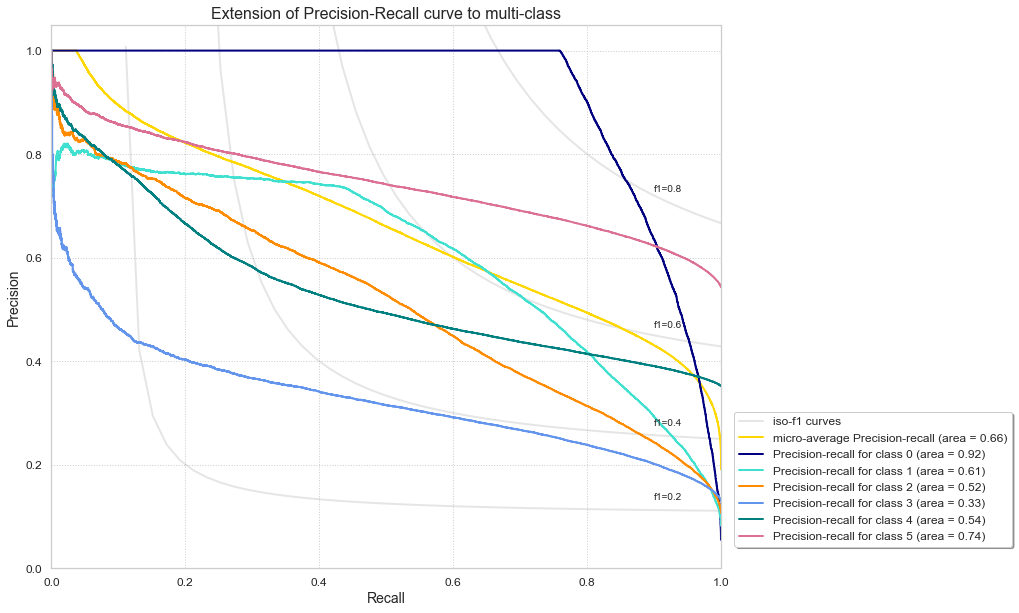

In [48]:
plot_PR_curve(xgb_recall, xgb_precision, xgb_ap, is_sep=True)

### Plot ROC  curve 

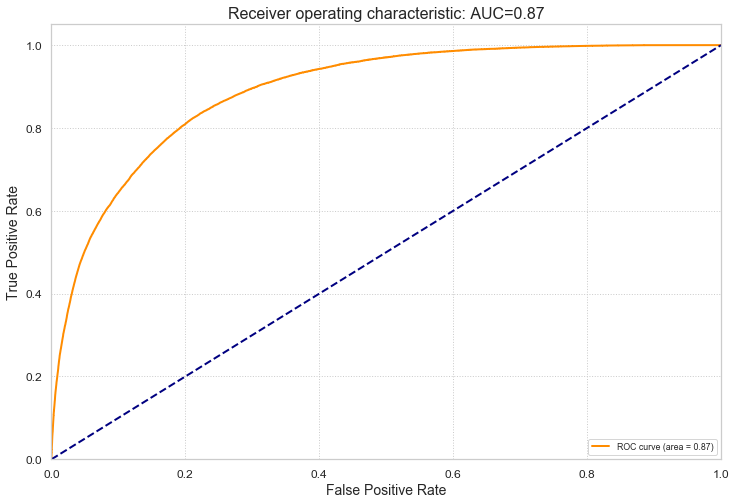

In [60]:
plot_ROC_curve(Y_test, y_xgb_score)

### Plot ROC curve for each class

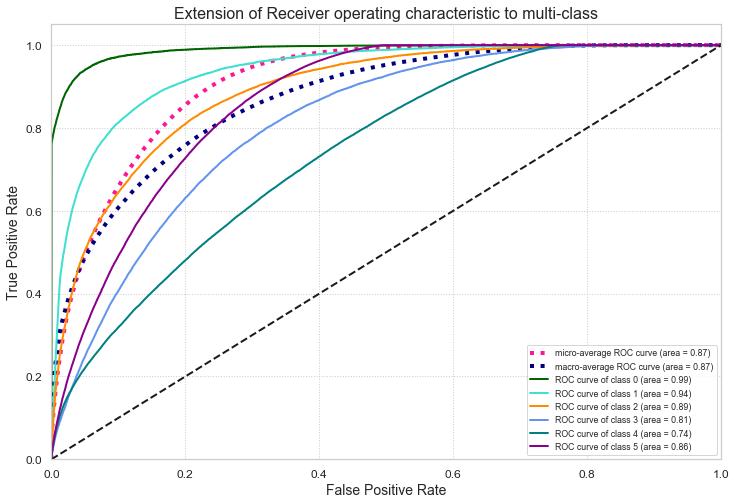

In [61]:
plot_ROC_curve(Y_test, y_xgb_score, is_sep=True)

Now, with default XGB classifier, we get 0.6609 of AP score and 0.8724 of AUC score. AP scores and ROC scores of individual clsses have improved compared to the optimal logistic model. When we see individual performance curves, we can observe that middle classes rating prediction performance has improved a lot even though the default XGBClassifier struggles more to distinguish middle rating classes 1,2,3, and 4 than to predict raiting 0 or 5. 

In [62]:
## Let us see 10 random picked true price values and predicted price values
compare_df = pd.DataFrame({'y_test': y_test, 'y_hat': y_hat})
ind = np.random.choice(len(compare_df), 10, replace=False)
compare_df.iloc[ind]

,y_test,y_hat
78151,5,5
1537,3,3
145297,4,5
164290,5,5
153815,4,4
122077,5,5
191333,3,4
137987,2,3
116208,4,5
49871,4,4


Default XGB classifier results in 0.6609 AP score and 0.8724 AUC score which is much better than those of optimal logistic regression model. Seemingly, predicted helpfulness ratings are off of true values by 1 and this is not bad. Now we can expect better performance from optimal XGBclassifier by grid search cross-validation approach.

### Important predictors

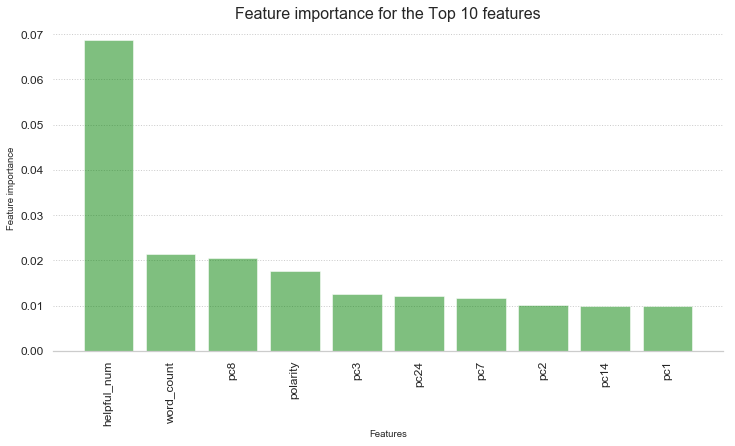

Top 10 important features:
 ['helpful_num', 'word_count', 'pc8', 'polarity', 'pc3', 'pc24', 'pc7', 'pc2', 'pc14', 'pc1']


In [63]:
## visualize it
features = sorted(zip(xgb_clf.feature_importances_, X_train.columns), reverse=True)
attr = []
coef = []
number = 10

for feature in features:
    attr.append(feature[1]) 
    coef.append(feature[0])

plt.figure(figsize=(12,6))
ax = plt.subplot()
ax.bar(attr[:number], height=coef[:number], color='green', alpha=0.5)
sns.despine(top=True, right=True, left=True)
ax.xaxis.grid(False)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature importance')
plt.title('Feature importance for the Top {} features'.format(number), fontsize=16)
plt.show()

## print features
print("Top {} important features:\n {}".format(number, attr[:number]))

According to default XGB classifier, helpful_num, word_count, and polarity play a important role to predict the review's helpfulness. This seems more reasonable than the result from the logistic regression model because as I mentioned in wrangling notebook, to get higher helpfulness rating, more people need to vote for the review. Also, polarity showed strong correlation to helpfulness (about 0.24) and so did word_count (about 0.18). However, Given that Books and Movies & TV categories account for about 55 % of entire dataset, it is interesting that they do not play important role to predict helpfulness ratings. As with the logistic model, XGB classifier implies that there exist important vocabulary groups that can help to distinguish reviews' helpfulness. 

### Confusion Matrix
To see individual class's performance, we can use confusion matrix. First I will provide non-normalized confusion matrix and then normalized (row-wise) confusion matrix.

Confusion matrix, without normalization
[[ 9259  2153   461    80   162    48]
 [   36  9416  4902  1162  2510   877]
 [    0  1987 10074  3370  6445  2663]
 [    0    31  2075  4435 13663  7578]
 [    0    18   426  1992 31404 38815]
 [    0     9    96   179  9781 82403]]


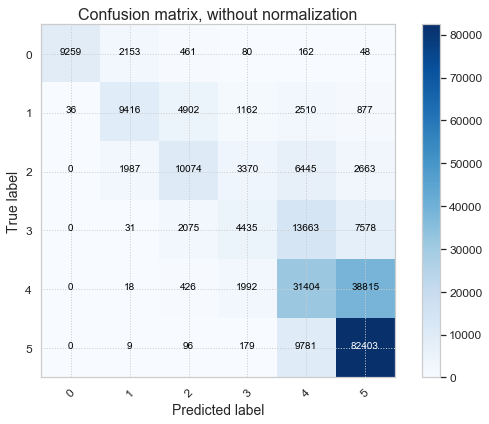

In [64]:
## compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat)
np.set_printoptions(precision=2)

class_names = xgb_clf.classes_

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[7.61e-01 1.77e-01 3.79e-02 6.58e-03 1.33e-02 3.95e-03]
 [1.90e-03 4.98e-01 2.59e-01 6.15e-02 1.33e-01 4.64e-02]
 [0.00e+00 8.10e-02 4.11e-01 1.37e-01 2.63e-01 1.09e-01]
 [0.00e+00 1.12e-03 7.47e-02 1.60e-01 4.92e-01 2.73e-01]
 [0.00e+00 2.48e-04 5.86e-03 2.74e-02 4.32e-01 5.34e-01]
 [0.00e+00 9.73e-05 1.04e-03 1.94e-03 1.06e-01 8.91e-01]]


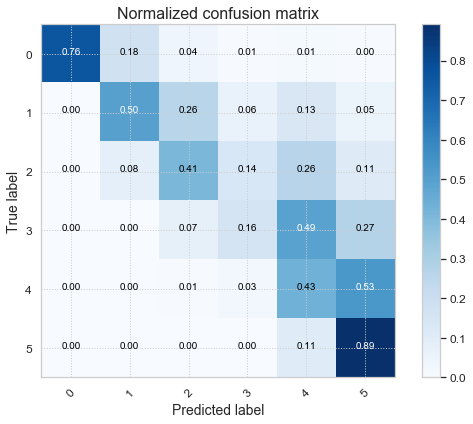

In [65]:
# Plot normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

One noticeable trend is beside true label is 0, data points are not predicted as helpfulness rating 0. Another trend is prediction error is reside mostly within range of +/- 1 from true class. Especially, the model has more strong tendency to inflate helpfulness rating than deflate. Last trend, is the model confuses class 3 with class 4. Looking at true label 3 row, the model predicted more data points as rating 4 or 5 than true label 3. Individual PR curve proves that the model poorly performs with class 3 data points. However, from practical perspective, this result is good enough because most shaded areas are congested along the diagonal line.

## Optimal XGB model
Let us tune parameters with gridsearchCV

In [66]:
## parameter dictionary holder
params = []

## candidate parameters (3x3x2x2x2x2 (144) combinations)
max_depths = [3, 4, 5]
learning_rates = [0.05, 0.1, 0.15]
min_child_weights = [1, 5]
subsamples = [0.8, 1]
reg_lambdas = [1, 5]
reg_alphas = [1, 5]
colsample_bytrees = [0.6, 0.8]

fit_params={'eval_metric':'mlogloss', 
            'early_stopping_rounds':5, 
            'eval_set':[(X_valid, y_valid)],
            'verbose':False}

start=time.time()
 
## manually grid search cv
for max_depth in max_depths:
    for learning_rate in learning_rates:
        for min_child_weight in min_child_weights:
            for subsample in subsamples:
                for reg_lambda in reg_lambdas:
                    for reg_alpha in reg_alphas:
                        for colsample_bytree in colsample_bytrees:
                            ## define hyper parameters for xgbclassifier
                            param = dict(booster='gbtree', objective='multi:softprob',
                                         num_class=6, seed=23, silent=True,
                                         max_depth=max_depth, 
                                         learning_rate=learning_rate,
                                         min_child_weight=min_child_weight,
                                         subsample = subsample, 
                                         reg_lambda=reg_lambda,
                                         reg_alpha=reg_alpha,
                                         colsample_bytree=colsample_bytree)
                            ## retrieve cv results dataframe
                            model = xgb.XGBClassifier(**param, n_estimators=640, n_jobs=128)
                            cv_score = cross_val_score(model, X_train_sub, y_train_sub, cv=skf, 
                                                       fit_params=fit_params, n_jobs=3, 
                                                       scoring='neg_log_loss').mean()
                            cv_score *= -1.0 # convert neg_log_loss to log_loss
                            ## append the score and parameters to params
                            params.append((cv_score, param))
                            
end = time.time()

## get best parameters that gives smallest validation log_loss score
params = sorted(params, key=lambda x: x[0])
best_params = params[0][1]
best_valid_score = params[0][0]

print("Running time for grid search with 3-fold CV: {:.0f} (sec)".format(end-start))
print("Best XGBclassifier parameters:")
print(best_params)

Running time for grid search with 3-fold CV: 292080 (sec)
Best XGBclassifier parameters:
{'booster': 'gbtree', 'objective': 'multi:softprob', 'num_class': 6, 'seed': 23, 'silent': True, 'max_depth': 3, 'learning_rate': 0.05, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 1, 'colsample_bytree': 0.6}


## *** RUNNING NOW *** 
### GO TO THE BOTTOM to see pc intepretation

In [ ]:
## train XGBClassifier with best parameters
start=time.time()
model = xgb.XGBClassifier(**best_params, n_estimators=2944, n_jobs=128)
model.fit(X_train_sub, y_train_sub, **fit_params)
end=time.time()
## print out results
print("runtime: {:.0f}".format(end-start))
print("Training logloss: {:>8.4f}".format(log_loss(y_train_sub, xgb_clf.predict_proba(X_train_sub))))
print("Validation logloss: {:.4f}".format(log_loss(y_valid, xgb_clf.predict_proba(X_valid))))
print("Test logloss: {:>12.4f}".format(log_loss(y_test, xgb_clf.predict_proba(X_test))))

[0]	validation_0-mlogloss:1.75213
Will train until validation_0-mlogloss hasn't improved in 5 rounds.
[1]	validation_0-mlogloss:1.71003
[2]	validation_0-mlogloss:1.67692
[3]	validation_0-mlogloss:1.65259
[4]	validation_0-mlogloss:1.6197
[5]	validation_0-mlogloss:1.58479
[6]	validation_0-mlogloss:1.55256
[7]	validation_0-mlogloss:1.52991
[8]	validation_0-mlogloss:1.5092
[9]	validation_0-mlogloss:1.48773
[10]	validation_0-mlogloss:1.46887
[11]	validation_0-mlogloss:1.4468
[12]	validation_0-mlogloss:1.42727
[13]	validation_0-mlogloss:1.40868
[14]	validation_0-mlogloss:1.39226
[15]	validation_0-mlogloss:1.37426
[16]	validation_0-mlogloss:1.36081
[17]	validation_0-mlogloss:1.34948
[18]	validation_0-mlogloss:1.33262
[19]	validation_0-mlogloss:1.31995
[20]	validation_0-mlogloss:1.31014
[21]	validation_0-mlogloss:1.29605
[22]	validation_0-mlogloss:1.28382
[23]	validation_0-mlogloss:1.2738
[24]	validation_0-mlogloss:1.26884
[25]	validation_0-mlogloss:1.26094
[26]	validation_0-mlogloss:1.25273
[

In [ ]:
## AP (Average Precision) and AUC (Area Under the Curve), precision, recall, 
## f1 scores on test data for each class
y_hat = xgb_clf.predict(X_test)
y_xgb_score = xgb_clf.predict_proba(X_test)
xgb_precision = dict()
xgb_recall = dict()
xgb_ap = dict()
for i in range(n_classes):
    xgb_precision[i], xgb_recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                                y_xgb_score[:, i])
    xgb_ap[i] = average_precision_score(Y_test[:, i], y_xgb_score[:, i])

# A "micro-average": quantifying score on all classes jointly
xgb_precision["micro"], xgb_recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
                                                                        y_xgb_score.ravel())
xgb_ap["micro"] = average_precision_score(Y_test, y_xgb_score, average="micro")
xgb_auc = roc_auc_score(Y_test, y_xgb_score)
xgb_f1 = f1_score(y_test, y_hat, average='micro')
xgb_acc = accuracy_score(y_test, y_hat)

print("Best XGB estimator micro-averaged AP score on test data:")
print("{:.4f}".format(xgb_ap["micro"]))
print("Best XGB estimator micro-averaged AUC score on test data:")
print("{:.4f}".format(xgb_auc))

### Plot the precision-Recall curve for best XGB classifier

In [ ]:
plot_PR_curve(xgb_recall, xgb_precision, xgb_ap)

### Plot Precision-Recall curve for each class and iso-f1 curves

In [ ]:
plot_PR_curve(xgb_recall, xgb_precision, xgb_ap, is_sep=True)

### Plot ROC  curve 

In [ ]:
plot_ROC_curve(Y_test, y_xgb_score)

### Plot ROC curve for each class

In [ ]:
plot_ROC_curve(Y_test, y_xgb_score, is_sep=True)

Now, with optimal XGB classifier, we get 0.6489 of AP score and 0.8832 of AUC score. AP scores and ROC scores of individual clsses have improved compared to the optimal logistic model. Improvement in middle classes are especially noticeable. With optimal XGB classifier, we can expect more accurate prediction on helpfulness of the review.

In [ ]:
## Let us see 10 random picked true price values and predicted price values
compare_df = pd.DataFrame({'y_test': y_test, 'y_hat': y_hat})
ind = np.random.choice(len(compare_df), 10, replace=False)
compare_df.iloc[ind]

Actuall helfpulness ratings are close to predicted ratings.

### Important predictors

In [ ]:
## visualize it
features = sorted(zip(xgb_clf.feature_importances_, X_train.columns), reverse=True)
attr = []
coef = []
number = 10

for feature in features:
    attr.append(feature[1]) 
    coef.append(feature[0])

plt.figure(figsize=(12,6))
ax = plt.subplot()
ax.bar(attr[:number], height=coef[:number], color='green', alpha=0.5)
sns.despine(top=True, right=True, left=True)
ax.xaxis.grid(False)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature importance')
plt.title('Feature importance for the Top {} features'.format(number), fontsize=16)
plt.show()

## print features
print("Top {} important features:\n {}".format(number, attr[:number]))

According to optimal XGB classifier, top 10 important features are same except for word_density. With optimal hyper-parameters of XGB classifier, all four numerical features made it to the list. So, we can conjecture that numerical features showed strong correlation indeed play a important role to predict the response - Helpfulness rating. 

### Confusion Matrix

In [ ]:
## compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat)
np.set_printoptions(precision=2)

class_names = xgb_clf.classes_

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Plot normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

This normalized confusion matrix summarizes the performance of our XGB classifier. As the table from In\[54] showed, we sensed that prediction is not far off. Looking at the confusion matrix, it says the model very accurately predict class 5 reviews and class 0 ones. It still struggles with middle class reviews, but mostly the mispredicted ratings are within 1 point difference. Yet, I belive this problem can be solved simply adding more reviews of class 0, 1, 2, and 3 given that XGB classifiers hunger for data and those classes have smaller data. 


## Interpret Principal Components
From important features figure, we learned that their may exist vocabulary groups that mainly compose principal component. In this section, let us decompose three principal components that played important roles and confirm that indeed there are word groups that defines a principal component. 

In [111]:
## let us see how weights changed based on pca component
def svd_nth_feature_weights(vectorizer, svd, n_component=1):
    weight = svd.components_[n_component-1].flatten()
    weight_df = pd.DataFrame({'feature': vectorizer.get_feature_names(), 'weight': weight, 'nth': n_component})
    return weight_df

def print_weights(vectorizer, svd, n_component=1, num=None):
    weight = svd.components_[n_component-1].flatten()
    weight_df = pd.DataFrame({'feature': vectorizer.get_feature_names(), 'weight': weight})
    weight_df = weight_df.sort_values(by='weight', ascending=False).set_index('feature')
    if num != None:
        temp = pd.concat([weight_df[:num], weight_df[-num:]])
        weight_df = temp.copy()
        del temp
    print(weight_df)
    return weight_df

def max_min_feature(dff):
    dff = dff.sort_values(by='weight', ascending=False)
    max_feat = (dff['feature'].iloc[0], dff['weight'].iloc[0])
    min_feat = (dff['feature'].iloc[-1], dff['weight'].iloc[-1])
    return max_feat, min_feat

<8th component>
Largest weight :  0.5795 (great)
Smallest weight: -0.1856 (money)

<3rd component>
Largest weight :  0.3571 (use)
Smallest weight: -0.3160 (movie)

<2nd component>
Largest weight :  0.7283 (book)
Smallest weight: -0.1585 (use)



Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x1a185d3860>>
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/xgboost/core.py", line 482, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


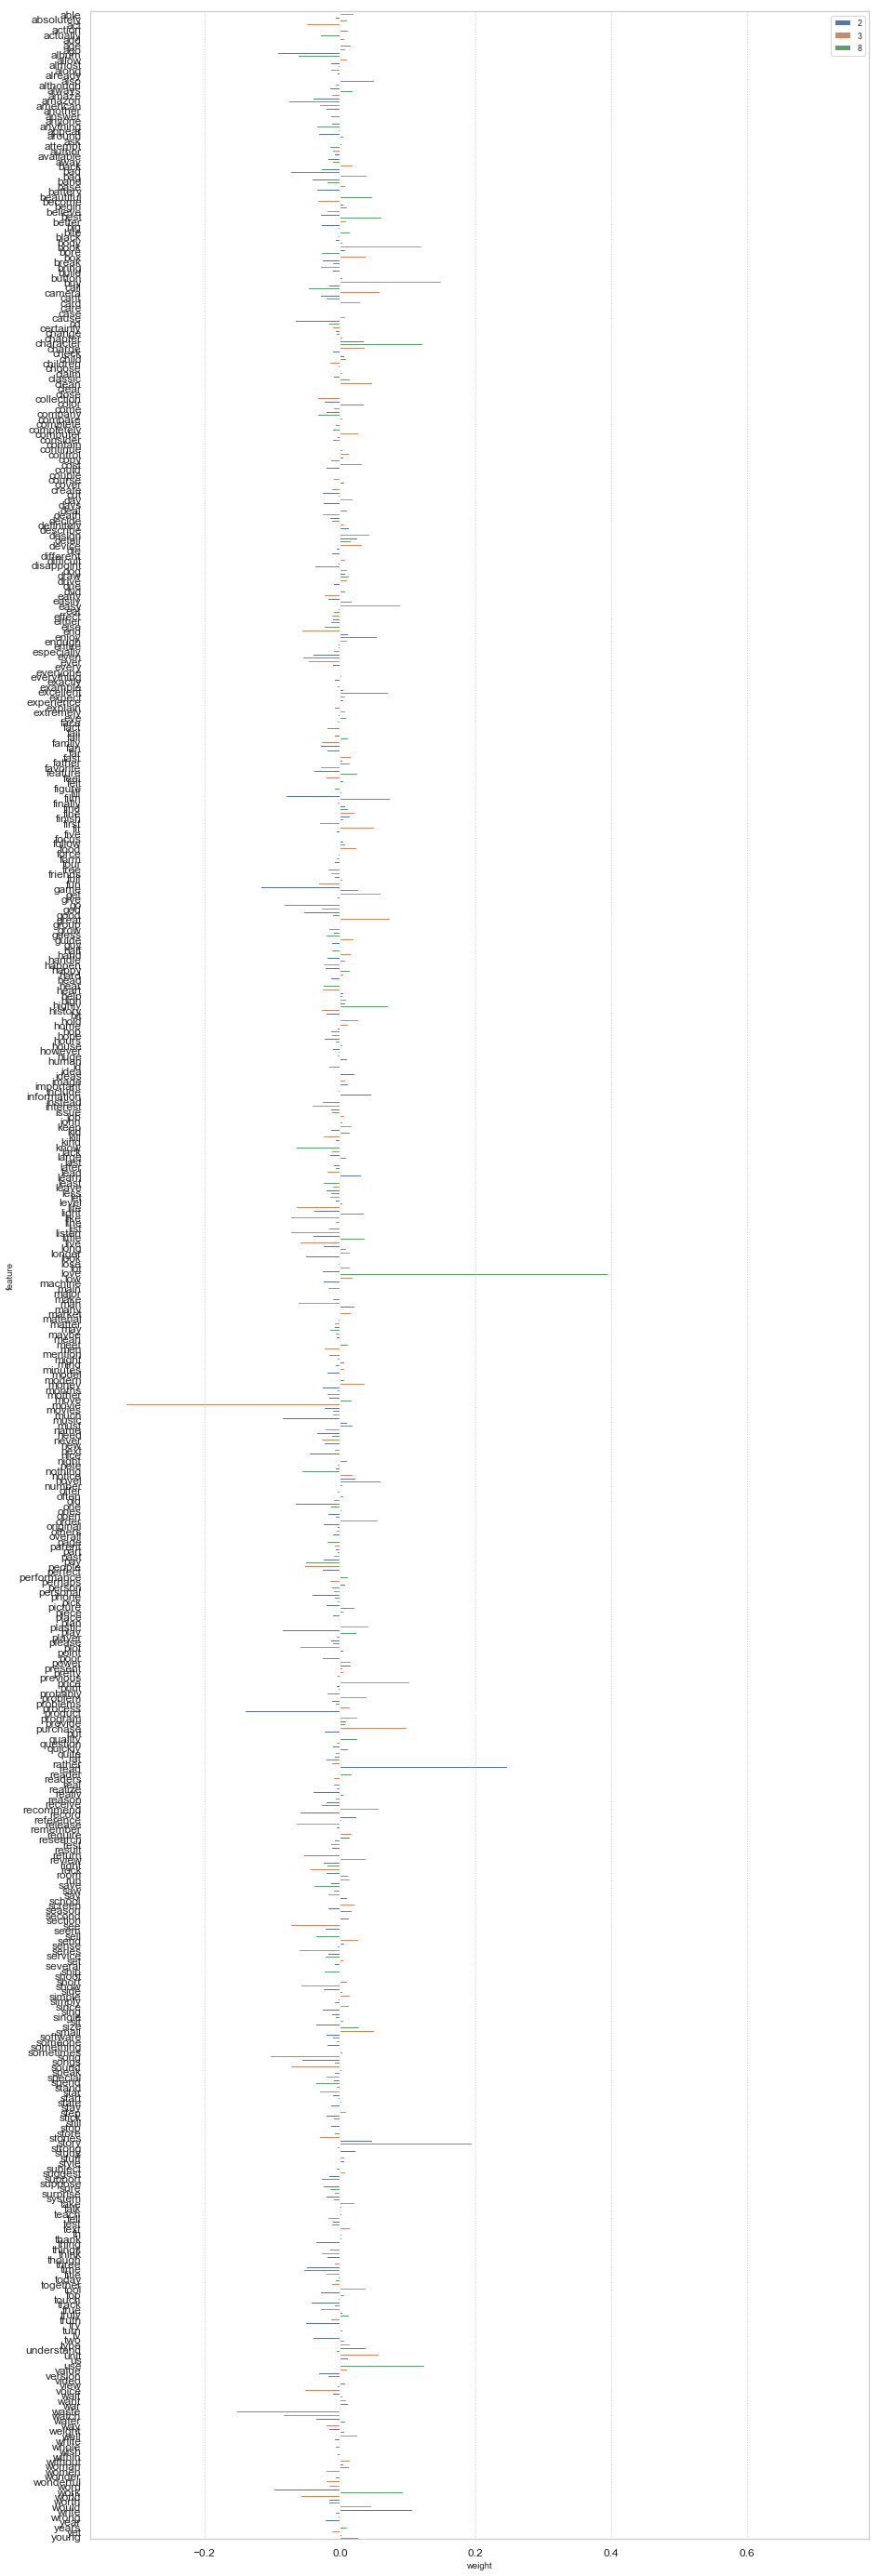

In [105]:
weight_df1 = svd_nth_feature_weights(vectorizer, svd, n_component=8)
weight_df2 = svd_nth_feature_weights(vectorizer, svd, n_component=3)
weight_df3 = svd_nth_feature_weights(vectorizer, svd, n_component=2)

## combine vertically
weight_df = pd.concat([weight_df1, weight_df2, weight_df3])

## print largest, smallest weight and feature for each coponent
max_feat, min_feat= max_min_feature(weight_df1)
print('<8th component>')
print('Largest weight : {:7.4f} ({})'.format(max_feat[1], max_feat[0]))
print('Smallest weight: {:7.4f} ({})'.format(min_feat[1], min_feat[0]))
print()
max_feat, min_feat= max_min_feature(weight_df2)
print('<3rd component>')
print('Largest weight : {:7.4f} ({})'.format(max_feat[1], max_feat[0]))
print('Smallest weight: {:7.4f} ({})'.format(min_feat[1], min_feat[0]))
print()
max_feat, min_feat= max_min_feature(weight_df3)
print('<2nd component>')
print('Largest weight : {:7.4f} ({})'.format(max_feat[1], max_feat[0]))
print('Smallest weight: {:7.4f} ({})'.format(min_feat[1], min_feat[0]))
print()

## visualize
plt.figure(figsize=(15, 50))
ax=sns.barplot(x='weight', y='feature', hue='nth', data=weight_df)
ax.legend(loc='upper right');

In [130]:
print_weights(vectorizer, svd, n_component=8, num=3);

           weight
feature          
great    0.579485
love     0.394742
story    0.194024
waste   -0.153219
buy     -0.169710
money   -0.185617


In [131]:
print_weights(vectorizer, svd, n_component=3, num=3);

           weight
feature          
use      0.357142
product  0.299746
work     0.164449
album   -0.198529
film    -0.270632
movie   -0.316048


In [132]:
print_weights(vectorizer, svd, n_component=2, num=3);

           weight
feature          
book     0.728313
read     0.247084
author   0.117357
game    -0.117141
product -0.140981
use     -0.158526


In [133]:
print_weights(vectorizer, svd, n_component=7, num=3);

           weight
feature          
read     0.343514
love     0.306757
story    0.214570
work    -0.130918
use     -0.192376
film    -0.298462


In [134]:
print_weights(vectorizer, svd, n_component=5, num=3);

           weight
feature          
movie    0.417120
film     0.335854
story    0.145734
cd      -0.245616
music   -0.253607
album   -0.387112


In [135]:
print_weights(vectorizer, svd, n_component=24, num=3);

           weight
feature          
write    0.353179
one      0.348599
love     0.281471
make    -0.167855
story   -0.181747
buy     -0.268042


## correlation matrix - to see if important features are positively to helpfulness

In [5]:
df_train.head()

,helpful_num,polarity,word_count,word_density,cat_Appliances,cat_Apps for Android,"cat_Arts, Crafts & Sewing",cat_Automotive,cat_Baby,cat_Baby Products,...,pc293,pc294,pc295,pc296,pc297,pc298,pc299,pc300,helpfulness,helpfulness_cont
0,0.079355,0.545238,0.618807,0.407405,-0.032487,-0.020164,-0.064545,-0.077054,-0.085983,-0.028077,...,1.228988,-0.675482,1.424845,0.537845,0.902128,-2.113010,0.518491,0.065815,5,4.642857
1,-0.242742,-0.901591,-0.086480,0.925712,-0.032487,-0.020164,-0.064545,-0.077054,-0.085983,-0.028077,...,0.515086,-0.866767,0.358773,0.197507,0.150096,-0.853313,-0.008761,-0.628204,2,1.904762
2,0.079355,-0.934753,-0.236999,-0.948043,-0.032487,-0.020164,-0.064545,-0.077054,-0.085983,-0.028077,...,-0.055160,0.248321,-0.900454,0.270392,1.057880,0.095681,0.080202,0.450757,5,4.814815
3,-0.189059,2.409138,-0.667051,-1.891284,-0.032487,-0.020164,-0.064545,-0.077054,-0.085983,-0.028077,...,-0.803379,-0.292562,0.747601,0.770148,-0.422974,0.148183,0.443413,0.307463,4,3.666667
4,-0.135376,-0.235439,0.042536,0.158281,-0.032487,-0.020164,-0.064545,-0.077054,-0.085983,-0.028077,...,1.124886,-1.230680,0.265488,0.394636,-2.050579,-0.537214,1.193532,0.162946,3,3.181818


In [6]:
df_test.head()

,helpful_num,polarity,word_count,word_density,cat_Appliances,cat_Apps for Android,"cat_Arts, Crafts & Sewing",cat_Automotive,cat_Baby,cat_Baby Products,...,pc293,pc294,pc295,pc296,pc297,pc298,pc299,pc300,helpfulness,helpfulness_cont
0,0.097249,0.101299,0.184453,1.635835,-0.032487,-0.020164,-0.064545,-0.077054,-0.085983,-0.028077,...,-0.345657,1.600091,-0.352617,0.224226,-0.737839,-0.362477,0.721077,0.301940,4,4.354839
1,-0.206953,0.011722,-0.073578,0.179621,-0.032487,-0.020164,-0.064545,-0.077054,-0.085983,-0.028077,...,-0.226017,-0.288725,0.165793,0.626736,1.226747,-1.705301,0.807695,1.193713,5,4.545455
2,-0.224847,-0.856343,-0.052076,-0.247294,-0.032487,-0.020164,-0.064545,-0.077054,-0.085983,-0.028077,...,-0.280764,0.598922,0.207041,-0.211342,1.546686,-3.212702,-1.744393,1.185748,3,3.214286
3,0.079355,-0.266421,-0.387517,1.524657,-0.032487,-0.020164,-0.064545,-0.077054,-0.085983,-0.028077,...,-0.178822,-0.360744,-0.995984,0.776671,1.194905,1.258488,-0.495515,0.295958,5,4.814815
4,-0.117482,-0.420820,1.552021,1.279106,-0.032487,-0.020164,-0.064545,-0.077054,-0.085983,-0.028077,...,0.638623,0.249135,-0.111067,-0.070593,1.094114,0.652545,0.225091,-1.091446,5,4.687500


In [10]:
df_train.drop(columns=['helpfulness_cont']).corr()

,helpful_num,polarity,word_count,word_density,cat_Appliances,cat_Apps for Android,"cat_Arts, Crafts & Sewing",cat_Automotive,cat_Baby,cat_Baby Products,...,pc292,pc293,pc294,pc295,pc296,pc297,pc298,pc299,pc300,helpfulness
helpful_num,1.000000,0.010920,0.161762,0.038222,0.002788,0.013863,0.003290,-0.001422,0.008107,0.001638,...,1.886902e-03,0.000543,-0.001016,7.935376e-04,-0.001906,-0.003885,0.001760,0.000180,0.003143,0.178104
polarity,0.010920,1.000000,-0.050926,-0.000475,-0.003365,-0.000827,0.010276,-0.000370,0.000743,-0.000622,...,9.197194e-03,-0.006842,-0.007080,-8.185555e-03,-0.003752,0.000817,-0.008501,0.015435,0.016297,0.239195
word_count,0.161762,-0.050926,1.000000,0.197725,-0.001889,-0.013979,-0.019857,-0.018756,-0.003267,-0.003962,...,2.624767e-03,-0.009708,0.003428,-4.054462e-03,-0.000927,-0.006712,0.011838,0.000529,0.010935,0.174127
word_density,0.038222,-0.000475,0.197725,1.000000,-0.011829,-0.022107,-0.030753,-0.038542,-0.054172,-0.012920,...,-1.083427e-02,0.013733,0.006122,1.227413e-02,0.012579,-0.011929,0.009569,-0.015678,-0.008504,0.102239
cat_Appliances,0.002788,-0.003365,-0.001889,-0.011829,1.000000,-0.000655,-0.002097,-0.002503,-0.002793,-0.000912,...,-2.309423e-03,0.000403,0.003071,-1.571779e-03,-0.002961,0.000723,0.001295,-0.003065,0.001246,0.011389
cat_Apps for Android,0.013863,-0.000827,-0.013979,-0.022107,-0.000655,1.000000,-0.001301,-0.001554,-0.001734,-0.000566,...,-4.481564e-04,0.002063,0.001547,-1.492230e-03,-0.000351,-0.000467,0.000116,0.002183,0.001003,-0.000894
"cat_Arts, Crafts & Sewing",0.003290,0.010276,-0.019857,-0.030753,-0.002097,-0.001301,1.000000,-0.004973,-0.005550,-0.001812,...,2.921909e-03,0.000957,0.002796,3.379602e-03,0.002433,-0.000572,-0.000789,0.003681,0.003347,0.027456
cat_Automotive,-0.001422,-0.000370,-0.018756,-0.038542,-0.002503,-0.001554,-0.004973,1.000000,-0.006625,-0.002163,...,2.257040e-03,-0.000189,0.004497,-3.223082e-03,-0.003965,-0.001596,0.000306,-0.002688,0.001232,0.016114
cat_Baby,0.008107,0.000743,-0.003267,-0.054172,-0.002793,-0.001734,-0.005550,-0.006625,1.000000,-0.002414,...,-2.168988e-03,-0.005876,-0.013144,5.779088e-03,-0.011023,0.005540,0.012293,0.006309,-0.005877,0.017597
cat_Baby Products,0.001638,-0.000622,-0.003962,-0.012920,-0.000912,-0.000566,-0.001812,-0.002163,-0.002414,1.000000,...,-2.357744e-03,-0.002531,-0.002440,3.337554e-03,-0.003368,0.003130,0.002917,0.002673,0.000825,0.005361


In [ ]:
df_train[['pc8', 'pc3', 'pc2', 'helpfulness']].corr()